## Real Estate Price Prediction
### Geekbrains AI/BigData Python for Data Science course competition

### Predictive models

In [1]:
import gc 
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from lightgbm import LGBMRegressor


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

from Real_Estate_formulas import FeatureImputer, FeatureGenetator, reduce_mem_usage

### 1. Data loading¶
data source: https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data_first150k.csv

#### Data fields
- Id - appartment ID
- DistrictId - district ID
- Rooms - the number of rooms
- Square - appartment area
- LifeSquare - living area
- KitchenSquare - kitchen area
- Floor - floor
- HouseFloor - the number of floors in the building
- HouseYear - the year of completion of the building
- Ecology_1, Ecology_2, Ecology_3 - ecological indicators of the district
- Social_1, Social_2, Social_3 - social indicators of the district
- Healthcare_1, Helthcare_2 - healthcare indicators of the building
- Shops_1, Shops_2 - indicators related to the number of shops, shopping malls in the distrint

In [2]:
path = 'C:/Users/ASER/Desktop/GeekBrains/ML_libraries/kaggle_project/'
df = pd.read_csv(path + 'train.csv')     # training set
X_final = pd.read_csv(path + 'test.csv') # test set

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

#### Reducing memory usage
Function reduce_mem_usage iterates through all the columns of a dataframe and modifies the data type to reduce memory usage.

In [3]:
df = reduce_mem_usage(df)
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [4]:
df.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.98156,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B,184966.9375
1,15053,41,3.0,65.68364,40.049541,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B,300009.4375


In [5]:
X = df.drop('Price', axis=1)
y = df[['Price']]

#X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('X.shape:', X.shape)
print('X_final.shape', X_final.shape)

gc.collect() 

X.shape: (10000, 19)
X_final.shape (5000, 18)


20

### 2. Data preprocessing

FeatureImputer performs the followitg data transformations:

Rooms: zeros were filled with 1, appartments with more than 6 rooms were filled with median Rooms
Square: 
* Square > 250 with Rooms < 4 or KitchenSquare <= 10 were filled with Square / 10
* Square < 13 with LifeSquare > 13 were filled with LifeSquare
* Square < 13 were filled with the median Square of ['DistrictId, HouseYear, Rooms]

KitchenSquare < 3 was filled with 3, KitchenSquare > 1000 was filled with KitchenSquare / 10

HouseFloor, Floor:
* The new variable HouseFloor_outlier were set for HouseFloor = 0 or HouseFloor < Floor
* If HouseFloor = 0, it was filled with median HouseFloor
* If Floor > HouseFloor, Floor is filled by HouseFloor

HouseYear:
* The new variable HouseYear_outlier were set for HouseYear > current_year
 
Helthcare_1 has been droped as nearly half of it's data is missing

LifeSquare:
* The new variable LifeSquare_nan were set for LifeSquare without data
* For LifeSquare < 8 or without any data if data for Square and KitchenSquare is avalible, LifeSquare is set as Square - KitchenSquare

In [6]:
imputer = FeatureImputer()
imputer.fit(X) 

X = imputer.transform(X)
X_final = imputer.transform(X_final)

### 3. Feature engineering

The new variables are generated by FeatureGenetator (Real_Estate_formulas.py).
FeatureGenetator performs target encoding of cathegorical variables DistrictID, Ecology_1, Shops_1, Social_1, Social_2, Social_3 and Helthcare_2 and generates new variables with median prices of each level: 
* MedPriceByDistrict,
* MedPriceByEcology_1,
* MedPriceByShops_1,
* MedPriceBySocial_1,
* MedPriceBySocial_2,
* MedPriceBySocial_3,
* MedPriceByHelthcare_2


Each of the variables Floor and HouseYear was split into groups and then jointly target encoded. The new variable - MedPriceByFloorYear.

The above variables together with Square, LifeSquare, Rooms, KitchenSquare and HouseYear were used in principal component analysis to generate 4 new composit variables:
* pca_composit_1, 
* pca_composit_2, 
* pca_composit_3,
* pca_composit_4.

Variables Square, LifeSquare, Rooms and KitchenSquare were clustered, split into 3 binary variables: Cluster_1, Cluster_2 and Cluster_3

Binary variables Ecology_2, Ecology_3 and Shops_2 were transformed to numbers 0 and 1.

In [7]:
features = FeatureGenetator()
features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [8]:
X.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictId_count',
 'new_district',
 'floor_cut',
 'year_cut',
 'MedPriceByDistrict',
 'MedPriceByEcology_1',
 'MedPriceByShops_1',
 'MedPriceBySocial_1',
 'MedPriceBySocial_2',
 'MedPriceBySocial_3',
 'MedPriceByHelthcare_2',
 'MedPriceByFloorYear',
 'pca_composit_1',
 'pca_composit_2',
 'pca_composit_3',
 'pca_composit_4',
 'Cluster_1',
 'Cluster_2',
 'Cluster_3']

#### Removal of redundant and irrelevant data

In [9]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 
                   'Floor', 'HouseFloor', 'HouseYear',
                   
                   'MedPriceByDistrict', 'MedPriceByEcology_1', 'MedPriceByShops_1', 
                   'MedPriceBySocial_1', 'MedPriceBySocial_2', 'MedPriceBySocial_3', 
                   'MedPriceByHelthcare_2', 'MedPriceByFloorYear',
                   
                   'pca_composit_1', 'pca_composit_2', 'pca_composit_3', 'pca_composit_4', 
                   
                   'LifeSquare_nan', 'DistrictId_count',
                   
                   'Ecology_3', 'Shops_2',
                   'Cluster_1']

X = X[remain_features]
X_final = X_final[remain_features]

### 4. Models

#### 1. LGBMRegressor

In [10]:
model = LGBMRegressor(max_depth=15, 
                             min_samples_leaf=10,
                             n_estimators=100, 
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.734 +- 0.019

R2: 0.734 +- 0.019


In [11]:
# training model on full train data set:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

#### Feature_importances

In [12]:
feature_importances = pd.DataFrame(zip(X.columns, 
                                       model.feature_importances_ / model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
1,Square,0.092667
6,HouseYear,0.069667
18,pca_composit_4,0.068667
2,LifeSquare,0.067000
16,pca_composit_2,0.063667
12,MedPriceBySocial_3,0.062333
17,pca_composit_3,0.060333
15,pca_composit_1,0.058000
7,MedPriceByDistrict,0.052333
10,MedPriceBySocial_1,0.049667


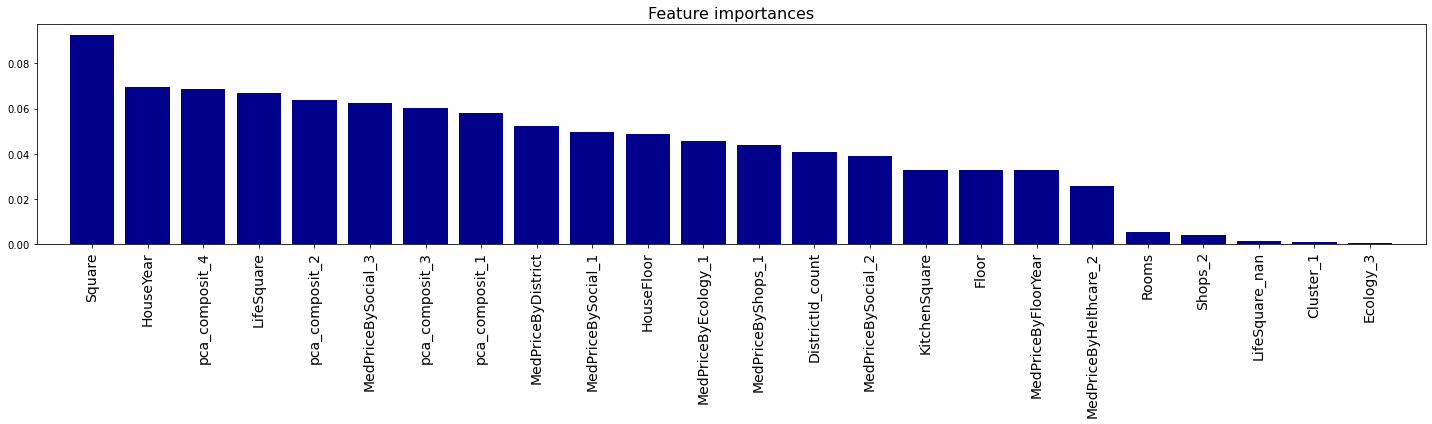

In [13]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

#### 2. RandomForestRegressor

In [14]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=15,  
                                 min_samples_leaf=30, 
                                 random_state=42,
                                
                                n_estimators=1000  
                                )
cv_score = cross_val_score(rf_model, X.fillna(0), y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.734 +- 0.019 - LGBMRegressor

R2: 0.700 +- 0.018


#### 3. VotingRegressor

In [15]:
v_model = VotingRegressor([('model', model), ('rf_model', rf_model)])

cv_score = cross_val_score(v_model, X.fillna(0), y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.734 +- 0.019 - LGBMRegressor

R2: 0.728 +- 0.018


### 5. Model hyperparameter tuning

#### 1. LGBMRegressor

In [16]:
lgb_model = LGBMRegressor(criterion='mse', 
                            min_samples_leaf=10,
                            random_state=42,
                         
                         # n_estimators=100,
                         # max_depth=7
                         
                         )

In [17]:
params = {'n_estimators':[100, 200, 300], 
          'max_depth':[7, 10, 15, 30]}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', 
                  cv=KFold(n_splits=4,   
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=10, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [7, 10, 15,

In [18]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 100}

#### 2. RandomForestRegressor

In [19]:
rf_model = RandomForestRegressor(criterion='mse',                                  
                                 min_samples_leaf=30, 
                                 random_state=42,
                                
                                #n_estimators=100  
                                )

In [20]:
params = {'n_estimators':[600, 800, 1000], 
          'max_depth':[15, 30, 40]}

rf_gs = GridSearchCV(rf_model, params, 
                  scoring='r2',  
                  cv=KFold(n_splits=4,   
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
rf_gs.fit(X.fillna(0), y)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=30,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbos

In [21]:
rf_gs.best_params_

{'max_depth': 15, 'n_estimators': 1000}

### 6. Final results

In [22]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv(path + 'predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,161325.154856
1,15856,231247.994318
2,5480,176188.056989
3,15664,265707.479025
4,14275,140728.934980


In [23]:
preds_final.shape

(5000, 2)